This notebook is made available under the GNU General Public License v3.0. (c) Francesco Mario Antonio Mitrotta 2022.

# Nonlinear Buckling Analysis of a Box Beam

***

In this notebook we apply MSC Nastran SOL 106's nonlinear buckling method to a cantilever box beam under different load conditions.

* [Geometry and material properties](#properties)
* [Setup of the numerical model](#numerical-model)
* [Uniform load over the top skin](#uniform-load)
    * [Mesh convergence study](#mesh-convergence)
    * [Nonlinear buckling method](#disrtibuted-load-flexible-tip)
        * [Rigid tip section](#distributed-load-rigid-tip)
* [Concentrated load at the tip](#concentrated-load)
    * [Flexible tip section](#concentrated-load-flexible-tip)
    * [Rigid tip section](#concentrated-load-rigid-tip)
* [Conclusions](#conclusions)

## Geometry and material properties <a name="properties"></a>

***

We consider an untapered cantilever thin-walled box beam with no internal reinforcement, as shown below.

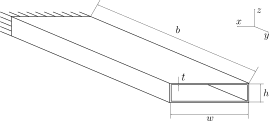

In [1]:
from IPython.display import SVG  # class to embed an SVG into the display
import os  # module with miscellaneous operating system interfaces

SVG(filename=os.path.join('resources', '04_BoxBeamGeometry.svg'))

Notice how the width $w$ and the height $h$ are measured from the thin walls' midplane. This is done to be consistent with our numerical model, where we'll use shell elements having their thickness developing simmetrically from the plane of the elements.

We define the geometric properties of our box beam with the aim of obtaining a scaled imitation of the Common Research Model (CRM, [Vassberg et al. 2008](https://arc.aiaa.org/doi/abs/10.2514/6.2008-6919)). For this reason we use an aspect ratio $2b/w=9$ and a non-dimensional height of $h/w=0.2$. For the wall thickness $t$ we use a $1/50$ ratio with respect to the height of the cross-section, in order to obtain a thin-walled structure. The width $w$ is set to $1$ m and the other dimensions follow from that.

In [2]:
AR = 9.   # aspect ratio - 2*b/w (the span of the box beam corresponds to half the span of the CRM wing)
w = 1e3   # width [mm]
b = AR*w/2  # span [mm]
non_dimensional_height = 0.2  # h/w
h = w*non_dimensional_height  # box height [mm]
non_dimensional_thickness = 1/50  # t/h
t = h*non_dimensional_thickness   # shell thickness [mm]
print(f'Box beam dimensions:\n- width: {w/1e3:.2f} m\n- span: {b/1e3:.2f} m\n- height: {h/1e3:.2f} m\n- wall thickness: {t:.2f} mm')

Box beam dimensions:
- width: 1.00 m
- span: 4.50 m
- height: 0.20 m
- wall thickness: 4.00 mm


Next we define the material properties of our box beam. We use the same values employed by [Brooks et al. (2018)](https://arc.aiaa.org/doi/10.2514/1.J056603) for the development of the undeflected CRM (uCRM).

In [3]:
rho = 2780e-12  # density [ton/mm^3]
E = 73.1e3  # Young's modulus [MPa]
nu = 0.3  # Poisson's ratio

Note that, similarly to our previous notebooks, we are going to use the _millimeter - newton - megapascal - ton_ system of units.

## Setup of the numerical model <a name="numerical-model"></a>

***

The first step to set up our numerical model consists in discretizing our geometry into quadrilateral shell elements. For this purpose we are going to use the function `mesh_box` from the `box_beam_utils` module, which includes useful functions to work with a box beam model. The function takes as input:
 - dimensions of the box;
 - prescribed edge length of the shell elements;

and it returns:
 - array with the xyz coordinates of the nodes;
 - array with their connectivity information.

For illustration purposes, let's discretize our box beam into quadrilateral elements with a prescribed edge lenght of 200 mm and let's visualize the discretized geometry.

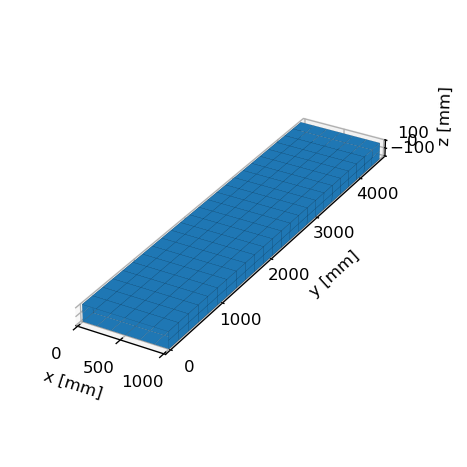

In [4]:
from resources import box_beam_utils  # module with useful function for box beam problems
import matplotlib.pyplot as plt  # plotting libary
import numpy as np  # arrays libary
from mpl_toolkits.mplot3d.art3d import Poly3DCollection  # class to create a collection of 3D polygons

# Discretize geometry
shell_length = 200  # [mm]
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=shell_length)

# Find coordinates of the nodes for each element
vertices = [None]*np.size(nodes_connectivity_matrix, 0)  # initialize list of (N, 3) array-like with coordinates of the nodes
for count, indices in enumerate(nodes_connectivity_matrix):  # iterate through the rows of the connectivity matrix (each row corresponds to a quadrilateral element)
    vertices[count] = nodes_coordinates_array[indices]  # store the coordinates of the nodes defining the current element

# Plot discretized geometry
plt.rcParams['figure.dpi'] = 120 # set default dpi of figures
fig = plt.figure()  # create new figure
ax = fig.add_subplot(111, projection='3d')  # create 3D axes
pc = Poly3DCollection(vertices, linewidths=.05)  # create 3D polygons representing the elements
pc.set_edgecolor('k')  # set polygons' edges black
ax.add_collection3d(pc)  # add polygons to the plot

# Set axes label
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
ax.set_zlabel('z [mm]')

# Set axes limits
x_coordinates = [func(points[:, 0]) for points in vertices for func in (np.min, np.max)]
y_coordinates = [func(points[:, 1]) for points in vertices for func in (np.min, np.max)]
z_coordinates = [func(points[:, 2]) for points in vertices for func in (np.min, np.max)]
ax.set_xlim(min(x_coordinates), max(x_coordinates))
ax.set_ylim(min(y_coordinates), max(y_coordinates))
ax.set_zlim(min(z_coordinates), max(z_coordinates))

# Set aspect ratio of the axes
ax.set_box_aspect([ub - lb for lb, ub in (getattr(ax, f'get_{a}lim')() for a in 'xyz')])

# We define a function to adjust axes ticks and labels' position, that we'll also use later
def set_ticks_and_labels_position(axes):
    axes.locator_params(axis='x', nbins=3)  # set number of ticks of x-axis
    axes.locator_params(axis='z', nbins=2)  # set number of ticks of z-axis
    axes.tick_params(axis='y', which='major', pad=20)  # adjust position of ticks' label of y-axis
    axes.tick_params(axis='z', which='major', pad=6)  # adjust position of ticks' label of z-axis
    axes.yaxis.labelpad = 60  # adjust position of y-axis's label
    axes.zaxis.labelpad = 10  # adjust position of z-axis's label

# Set axes ticks and labels' position and show plot
set_ticks_and_labels_position(ax)
plt.show()

Next we need to create a base Nastran input including material properties, element properties, nodes, CQUAD4 elements, boundary conditions and some default options to set up the output files. We'll do this using the function `create_base_bdf_input` from the `box_beam_utils` module. This function takes as input:
 - material properties;
 - wall thickness;
 - arrays obtained from the `mesh_box` function.

It returns a `BDF` object including the following cards:
 - MAT1 to define an isotropic material;
 - PSHELL to define the properties of the shell elements;
 - GRID and CQUAD4 to define nodes and quadrilateral shell elements, respectively;
 - SPC1 to define the boundary conditions, corresponding to clamped nodes along the root section of the box beam;
 - PARAM cards and case control commands to set up the output files.

Let's create a bdf input using the discretization obtained earlier and let's print the cards included in it.

In [5]:
example_box_beam_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
print(example_box_beam_input.get_bdf_stats())

---BDF Statistics---
SOL None

bdf.spcs[1]: 1
  SPC1:    1

bdf.params: 0
  PARAM    : 1

bdf.nodes: 0
  GRID     : 400

bdf.elements: 0
  CQUAD4   : 384

bdf.properties: 0
  PSHELL   : 1

bdf.materials: 0
  MAT1     : 1




subcase=0 already exists...skipping


## Uniform load over the top skin <a name="uniform-load"></a>

***

The first loading condition that we consider is a uniformly distributed load $P$ over the top skin, as shown below. This is meant to represent a surrogate of the aerodynamic load.

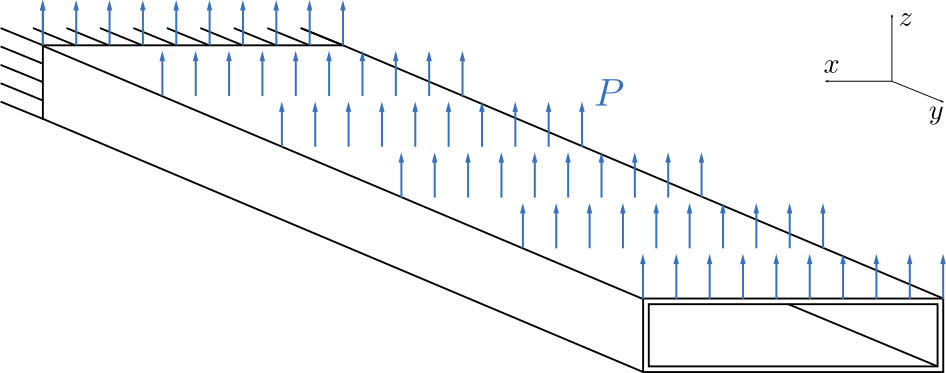

In [6]:
SVG(filename=os.path.join('resources', '04_BoxBeamUniformLoad.svg'))

We define the function `apply_distributed_load_over_top_skin` to apply the mentioned load. This function finds the ids of the top skin nodes and then calls the function `add_unitary_force` from the `pynastran_utils` module. This in turn adds a FORCE card defining a force along the $z$ axis to every node of the top skin, in such a way that the total applied load is 1 N. In this way we will be able to easily scale the magnitude of the total applied load in our analyses.

In [7]:
from resources import pynastran_utils  # module with useful functions to work with pyNastran objects

force_set_id = 11  # define FORCE card identification number

# Function to apply a distributed load over the top skin
def apply_distributed_load_over_top_skin(bdf_input, nodes_xyz_array):
    ids = np.arange(1, np.size(nodes_xyz_array, 0) + 1)  # retrieve id of all nodes
    top_skin_ids = ids[nodes_xyz_array[:,2]==h/2]  # find id of nodes with z = h/2 (top skin nodes)
    pynastran_utils.add_unitary_force(bdf_object=bdf_input, nodes_ids=top_skin_ids, set_id=force_set_id, direction_vector=[0, 0, 1])  # define unitary force along z over the top skin

### Mesh convergence study <a name="mesh-convergence"></a>

In order to establish an appropriate mesh size for our analyses, we need to perform a mesh convergence study. Since we want to study the buckling behavior of the box beam, we are going to assess the mesh convergence by monitoring the linear buckling load predicted by SOL 105 as the mesh is refined. For this purpose we are going to use the `run_sol_105_buckling_analysis` function from the `pynastran_utils` module, that calculates the linear buckling load taking as input a `BDF` object. This functions performs the following steps:
- assign solution sequence 105 to the input `BDF` object;
- create the first subcase for the application of the static load. The function takes as input a set idenfitication number corresponding to the applied load. As a consequence, `apply_uniform_load_over_top_skin` has to be called before `run_sol_105_buckling_analysis` to define the applied load;
- add an `EIGRL` card to define the calculation of the first positive eigenvalue using the Lanczos method;
- create the second subcase for the calculation of the buckling load;
- write the input file and run the analysis;
- read the results in the op2 file and return the corresponding `OP2` object.

We can then find the critical buckling load by multiplying the applied load by the eigenvalue found by SOL 105. Since we apply a unitary load, the eigenvalue is going to correspond to the buckling load. Let's calculate and print the linear buckling load for the example model created earlier.

In [8]:
# Define name of analysis directory
analysis_directory_name = '04_Nonlinear_Buckling_Analysis_of_a_Box_Beam'
analysis_directory_path = os.path.join(os.getcwd(), 'analyses', analysis_directory_name)

# Apply uniform load to example bdf input
apply_distributed_load_over_top_skin(example_box_beam_input, nodes_coordinates_array)

# Run SOL 105 and return OP2 object
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=example_box_beam_input, static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='linear_buckling_example', run_flag=False)

# Find critical buckling load and print it
eigenvalue_calculation_subcase_id = 2
linear_buckling_load = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling load: {linear_buckling_load:.0f} N')

Buckling load: 4097 N


We can also plot the critical buckling mode calling the function `plot_buckling_mode` from the `pynastran_utils` module and passing the `OP2` object as input argument.

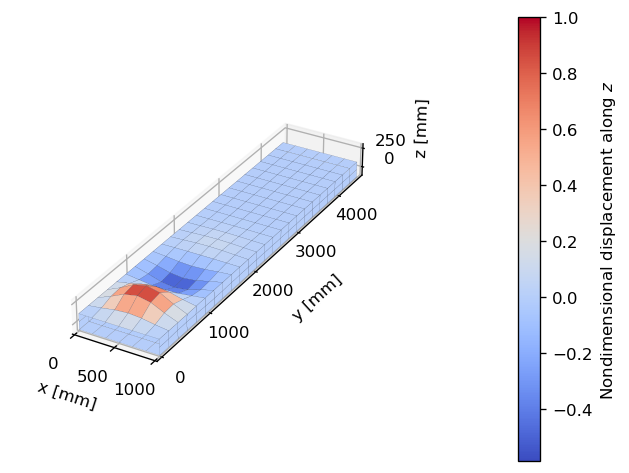

In [9]:
_, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='tz', colormap='coolwarm')
set_ticks_and_labels_position(ax)
plt.show()

Now we can run our mesh convergence study. We define 10 different linear sizes of the shell elements, evenly spaced on a log scale between the height of the box beam and four times the thickness of the shell elements.

In [10]:
# Define shell elements' edge lengths to be used for the mesh convergence study and print them to screen
edge_lengths = np.geomspace(h, t*4, 10) # [mm]
print('Prescribed edge length of shell elements for mesh convergence study [mm]:')
np.set_printoptions(precision=0)
print(edge_lengths)

Prescribed edge length of shell elements for mesh convergence study [mm]:
[200. 151. 114.  86.  65.  49.  37.  28.  21.  16.]


For each shell element size we generate the bdf input, apply the load, run SOL 105, find the critical buckling load and plot the critical buckling mode. We also store the value of the buckling load, together with the number of elements and the number of degrees of freedom of the model.


Running model with:
- 200 mm prescribed edge length
- 384 elements
- 2304 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 4097 N
Buckling mode:


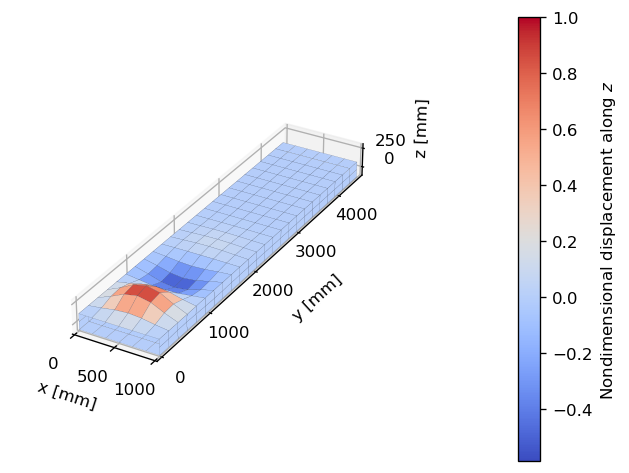


Running model with:
- 151 mm prescribed edge length
- 600 elements
- 3600 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3995 N
Buckling mode:


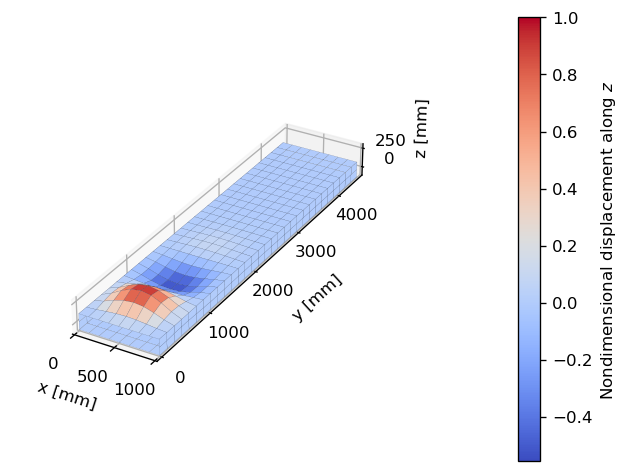


Running model with:
- 114 mm prescribed edge length
- 960 elements
- 5760 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3942 N
Buckling mode:


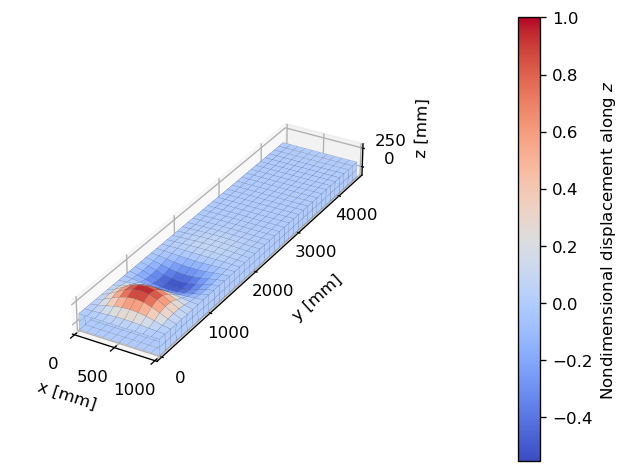


Running model with:
- 86 mm prescribed edge length
- 1728 elements
- 10368 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3915 N
Buckling mode:


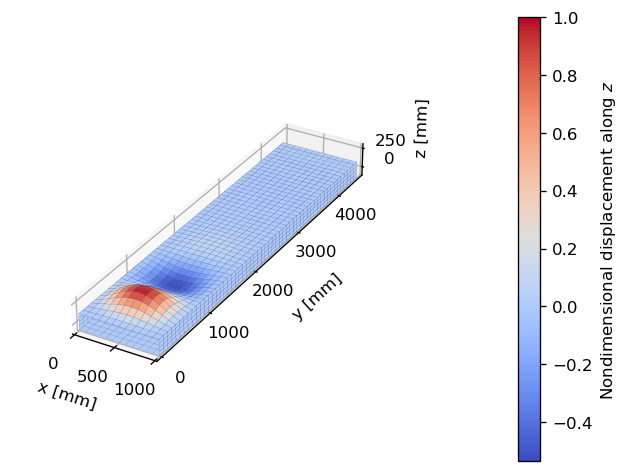


Running model with:
- 65 mm prescribed edge length
- 2800 elements
- 16800 degrees of freedom


subcase=0 already exists...skipping


Buckling load: 3908 N
Buckling mode:


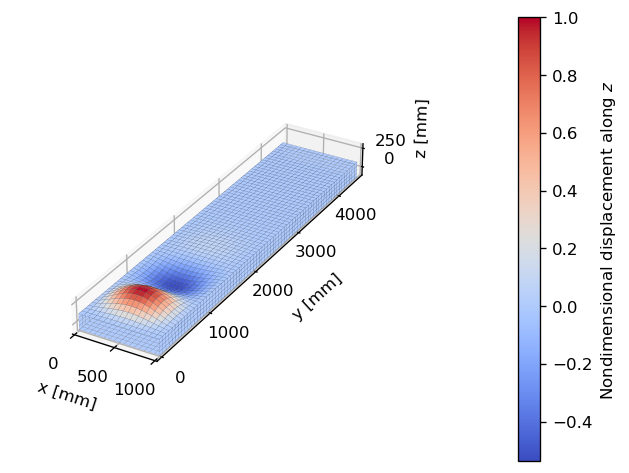

subcase=0 already exists...skipping



Running model with:
- 49 mm prescribed edge length
- 5152 elements
- 30912 degrees of freedom
Nastran job distributed_load_linear_buckling_5152_elements.bdf completed
Wall time: 4.0 s


Buckling load: 3909 N
Buckling mode:


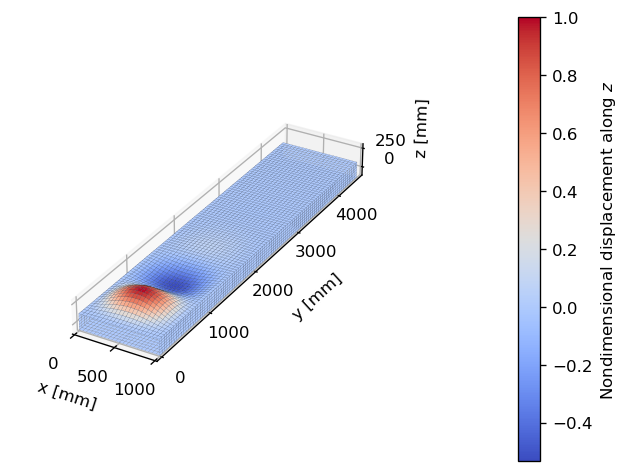

subcase=0 already exists...skipping



Running model with:
- 37 mm prescribed edge length
- 8296 elements
- 49776 degrees of freedom
Nastran job distributed_load_linear_buckling_8296_elements.bdf completed
Wall time: 4.0 s


Buckling load: 3911 N
Buckling mode:


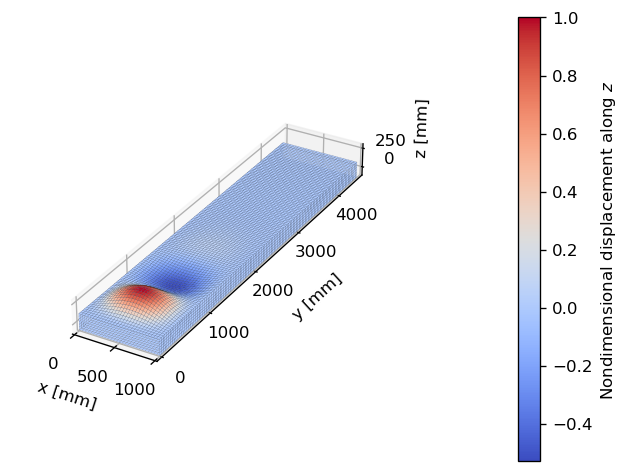

subcase=0 already exists...skipping



Running model with:
- 28 mm prescribed edge length
- 14256 elements
- 85536 degrees of freedom
Nastran job distributed_load_linear_buckling_14256_elements.bdf completed
Wall time: 7.0 s


Buckling load: 3915 N
Buckling mode:


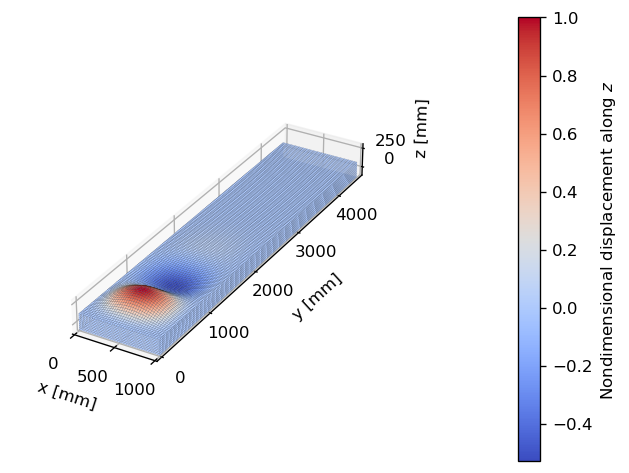

subcase=0 already exists...skipping



Running model with:
- 21 mm prescribed edge length
- 24824 elements
- 148944 degrees of freedom
Nastran job distributed_load_linear_buckling_24824_elements.bdf completed
Wall time: 13.0 s


Buckling load: 3917 N
Buckling mode:


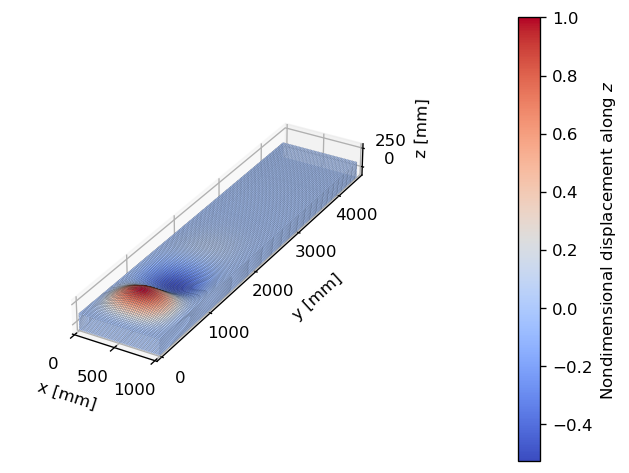

subcase=0 already exists...skipping



Running model with:
- 16 mm prescribed edge length
- 43992 elements
- 263952 degrees of freedom
Nastran job distributed_load_linear_buckling_43992_elements.bdf completed
Wall time: 27.0 s


Buckling load: 3919 N
Buckling mode:


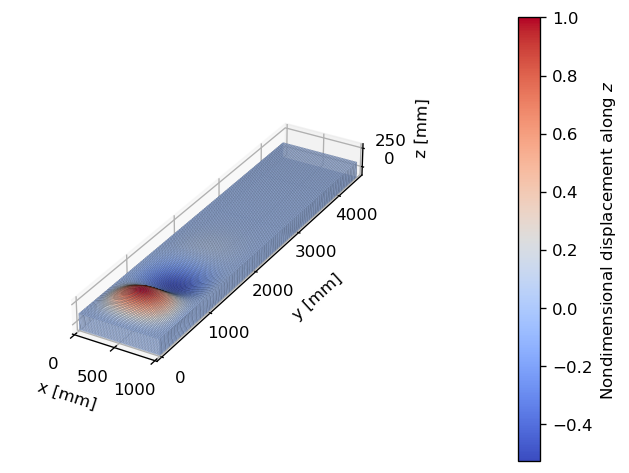

In [11]:
# Initialize arrays with number of elements, number of degrees of freedom and linear buckling loads
no_elements = np.empty(np.shape(edge_lengths), dtype=int)
dofs = np.empty(np.shape(edge_lengths))
linear_buckling_loads = np.empty(np.shape(edge_lengths))

# Iterate through the different edge lengths
for count, edge_length in enumerate(edge_lengths):
    # Generate bdf input
    nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=edge_length)
    linear_buckling_bdf = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
    # Store number of elements and number of degrees of freedom of current model
    no_elements[count] = len(linear_buckling_bdf.elements)
    constrained_nodes_ids = next(iter(linear_buckling_bdf.spcs.values()))[0].node_ids
    dofs[count] = (len(linear_buckling_bdf.nodes) - len(constrained_nodes_ids))*6
    # Apply uniform load over the top skin
    apply_distributed_load_over_top_skin(linear_buckling_bdf, nodes_coordinates_array)
    # Run SOL 105
    print(f'\n\033[1mRunning model with:\n- {edge_length:.0f} mm prescribed edge length\n- {no_elements[count]:.0f} elements\n- {dofs[count]:.0f} degrees of freedom\033[0m')
    input_name = 'distributed_load_linear_buckling_' + str(no_elements[count]) + '_elements'
    # Run SOL 105 and return OP2 object
    sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=linear_buckling_bdf, static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name=input_name, run_flag=False)
    # Find critical buckling load and print it
    linear_buckling_loads[count] = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
    print(f'Buckling load: {linear_buckling_loads[count]:.0f} N')
    # Plot critical buckling mode
    print(f'Buckling mode:')
    _, ax = pynastran_utils.plot_buckling_mode(op2_object=sol_105_op2, subcase_id=eigenvalue_calculation_subcase_id, displacement_component='tz', colormap='coolwarm')
    set_ticks_and_labels_position(ax)
    plt.show()

Once the linear buckling analysis has been run for all mesh sizes, we can plot the results. On the same figure we plot the buckling loads and the percentage difference with respect to the load obtained with the coarser mesh versus the number of degrees of freedom.

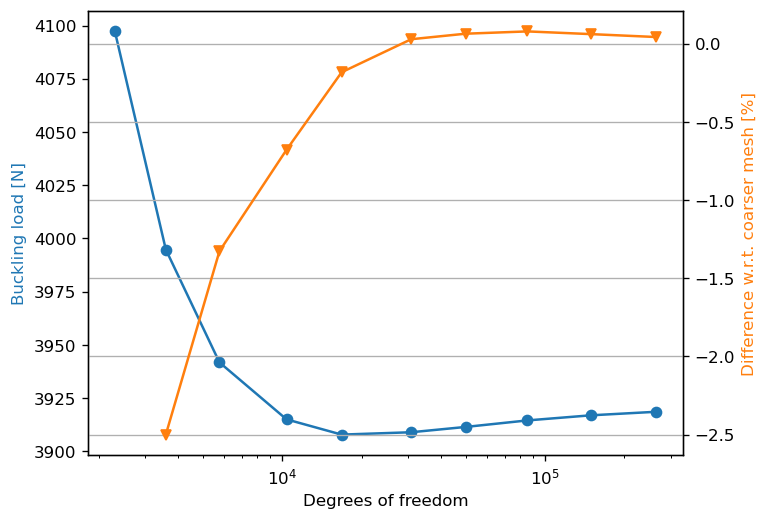

In [12]:
# Plot buckling loads vs degrees of freedom with a log scale along the x-axis
buckling_load_line = plt.semilogx(dofs, linear_buckling_loads, 'o-')

# Plot percentage difference vs degrees of freedom
ax1 = plt.gca()  # retrieve current axes object of the plot
ax2 = ax1.twinx()  # add second y-axis to the plot sharing the x-axis with the first axes object
percentage_diff = (linear_buckling_loads[1:]/linear_buckling_loads[0:-1]-1)*100  # calculate the percentage difference of each buckling load with respect to the one obtained with the coareser mesh
percentage_diff_line = ax2.plot(dofs[1:], percentage_diff, 'v-', color='tab:orange')

# Set plot appearance
ax1.set_xlabel('Degrees of freedom')
ax1.set_ylabel('Buckling load [N]', color=buckling_load_line[0].get_color())
ax2.set_ylabel('Difference w.r.t. coarser mesh [%]', color=percentage_diff_line[0].get_color())
plt.grid()
plt.show()

We see that initially the buckling load has a sharp decrease as the number of degrees of freedom grows, and then it increases sligthly converging to a value between 3900 and 3925 N. We define the mesh to be converged when the percentage difference of the buckling loads falls below 1%.

In [13]:
converged_mesh_index = np.where(np.abs(percentage_diff) < 1)[0][0] + 1  # find index of the edge length array corresponding to where the percentage difference is below 1
converged_edge_length = edge_lengths[converged_mesh_index]  # store shell length of converged mesh
linear_buckling_load = linear_buckling_loads[converged_mesh_index]  # store buckling load of converged mesh
print(f'The mesh is converged for a prescribed shell element edge of {converged_edge_length:.0f} mm, corresponidng to {no_elements[converged_mesh_index]:.0f} elements, {dofs[converged_mesh_index]:.0f} degrees of freedom and to a linear buckling load of {linear_buckling_load:.0f} N.')

The mesh is converged for a prescribed shell element edge of 86 mm, corresponidng to 1728 elements, 10368 degrees of freedom and to a linear buckling load of 3915 N.


### Nonlinear buckling method <a name="disrtibuted-load-flexible-tip"></a>

Now we want to analyze the buckling behavior of our box beam with SOL 106's nonlinear buckling method. We already explained and used this method for the calculation of the [buckling load of Euler's column](01_Buckling_Analysis_of_Euler_Column.ipynb#nonlinear-buckling). Here we want to investigate how the critical buckling load and mode change for different magnitudes of the applied load. In order to do this, we are going to define a sequence of subcases with increasing applied loads, where for each of these we calculate the critical buckling load and mode.

Let's create the base bdf input for our nonlinear analysis using the shell element edge length reported earlier and let's apply a distributed load to the top skin.

In [14]:
nodes_coordinates_array, nodes_connectivity_matrix = box_beam_utils.mesh_box(width=w, span=b, height=h, edge_length=converged_edge_length)  # disretize geometry
nonlinear_buckling_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)  # create base BDF object
apply_distributed_load_over_top_skin(nonlinear_buckling_input, nodes_coordinates_array)  # add distributed load to BDF object

subcase=0 already exists...skipping


 Then we define the function `run_nonlinear_buckling_method_sweep` to set up and run SOL 106 using the nonlinear buckling method. Since we want to investigate increasing applied loads, we define the function to receive as input a list of applied load magnitudes and to create a subcase for each of those.

The nonlinear analysis is set up by calling the function `set_up_arc_length_method` from the `pynastran_utils` module. This function selects SOL 106 as solution sequence, enables large displacement effects with the `PARAM,LGDISP,1` command, and adds the NLPARM and the NLPCI cards. For these cards we use the same parameters employed in our previous notebooks. Then `run_nonlinear_buckling_method_sweep` continues with the definition of the parameters for the buckling analysis, with the creation of the load sets and of the associated subcases. In this way the analysis calculates a buckling load for each subcase, and consequently for each applied load. Finally, the function runs the analysis, reads the op2 file and returns the `OP2` object.

In [15]:
from pyNastran.op2.op2 import read_op2  # function to read the op2 output of Nastran

# Function to set up the nonlinear analysis with the nonlinear buckling methods for increasing applied loads
def run_nonlinear_buckling_method_sweep(bdf_input, load_magnitudes, input_filename, run_flag=True):
    # Set up nonlinear analysis with arc-length method
    pynastran_utils.set_up_arc_length_method(bdf_object=bdf_input, ninc=100, max_iter=25, conv='PUV', eps_p=1e-3, eps_u=1e-3, max_bisect=10, minalr=.01, maxalr=1.1, desiter=5, maxinc=1000)
    # Define parameters for buckling analysis
    bdf_input.add_param('BUCKLE', [2])
    eigrl_set_id = force_set_id+1
    bdf_input.add_eigrl(sid=eigrl_set_id, v1=0., nd=1)  # calculate only the first positive eigenvalue
    bdf_input.case_control_deck.subcases[0].add_integer_type('METHOD', eigrl_set_id)
    # Create the LOAD cards corresponding to the input load magnitudes and the associated subcases
    for i, scale_factor in enumerate(load_magnitudes):
        load_set_id = 21+i
        bdf_input.add_load(sid=load_set_id, scale=1., scale_factors=[scale_factor], load_ids=[force_set_id])
        pynastran_utils.create_static_load_subcase(bdf_object=bdf_input, subcase_id=i+1, load_set_id=load_set_id)
    # Run analysis
    pynastran_utils.run_analysis(directory_path=analysis_directory_path, bdf_object=bdf_input, filename=input_filename, run_flag=run_flag)
    # Read op2 file
    op2_filepath = os.path.join(analysis_directory_path, input_filename + '.op2')
    op2 = read_op2(op2_filename=op2_filepath, load_geometry=True, debug=None)
    # Return op2 object
    return op2

We define 4 different subcases with increasing applied loads. These are evenly spaced between 1 N and the linear buckling load predicted by SOL 105, so about 3915 N. We consider only 1 N for the first subcase because we want to verify the behavior of SOL 106's nonlinear buckling method when the structure is deformed only slightly and thus it is very close to its undeformed state. For such situation, we expect SOL 106 to predict a buckling load very close to the one predicted by SOL 105.

In [16]:
applied_load_magnitudes = np.linspace(1, linear_buckling_load, 4)
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

Applied loads [N]: [   1. 1306. 2610. 3915.]


We define the maximum load equal to the critical buckling load predicted by SOL 105 and we call the `run_nonlinear_buckling_method_sweep` function.

In [17]:
input_name = 'distributed_load_flexible_tip_nonlinear_buckling_method'
op2_output = run_nonlinear_buckling_method_sweep(nonlinear_buckling_input, applied_load_magnitudes, input_name, run_flag=False)

Nastran job distributed_load_flexible_tip_nonlinear_buckling_method.bdf completed
Wall time: 44.0 s


We want to plot the buckling loads predicted by SOL 106 $P_\text{SOL 106}$ and the critical buckling factors $\alpha$ against the applied loads $P$. We define a function to do so and we nondimensionalize all loads with the buckling load predicted by SOL 105, $P_\text{SOL 105}$. In the $\alpha - P/P_\text{SOL 105}$ plot we also draw the $\alpha=1$ line to verify the reliability of the prediction.

In [18]:
# Function to plot SOL 106 buckling loads and critical buckling factors against applied loads
def plot_buckling_loads(applied_loads, sol_105_buckling_load, sol_106_buckling_loads, alphas):
    _, axs = plt.subplots(nrows=2, ncols=1, sharex='all')  # figure with 2 subplots
    axs[0].plot(applied_loads/sol_105_buckling_load, sol_106_buckling_loads/sol_105_buckling_load, '-o')  # buckling loads vs applied loads
    axs[1].plot(applied_loads/sol_105_buckling_load, alphas, 'o')  # critical buckling factors vs applied loads
    axs[1].axhline(y=1, color='k', ls='--', label='$\\alpha=1$')  # alpha=1 reference line
    # Set plot appearance
    axs[0].set_ylabel('$P_\mathrm{SOL\/106}/P_\mathrm{SOL\/105}$')
    axs[0].grid(visible=True)
    axs[1].set_ylabel('$\\alpha$')
    axs[1].grid(visible=True)
    axs[1].legend()
    axs[1].set_xlabel('$P/P_\mathrm{SOL\/105}$')
    axs[1].set_ylim([0, 60])
    plt.show()

Now let's find the nonlinear buckling load and the critical buckling factor for each subcase using the function `read_nonlinear_buckling_load_from_f06` from the `pynastran_utils` module and let's plot our results.

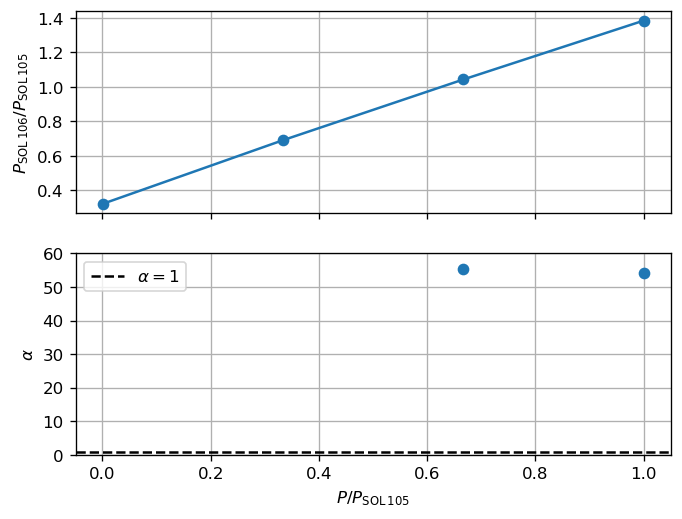

In [19]:
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

Note that when we don't see a point in the $\alpha$ plot, it means that the value fot that subcase is out of scale with respect to the range chosen for the display of the plot.

Finally, for each subcase we also plot the nonlinear deformation of the structure and the predicted buckling shape. We define an appropriate function for each task.

Applied load: 1 N
Nonlinear deformation:


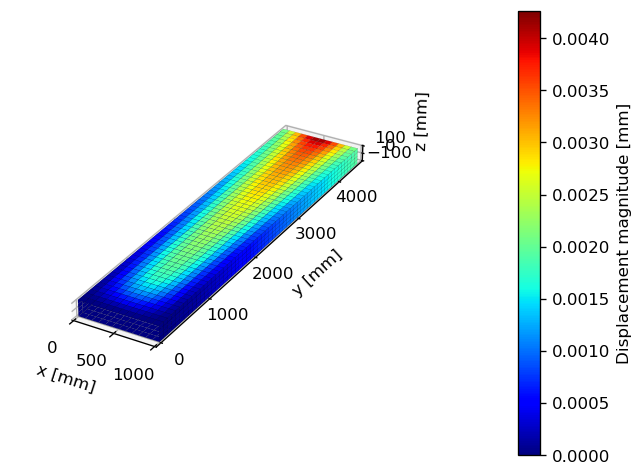

Predicted buckling load: 1261 N
Buckling shape:


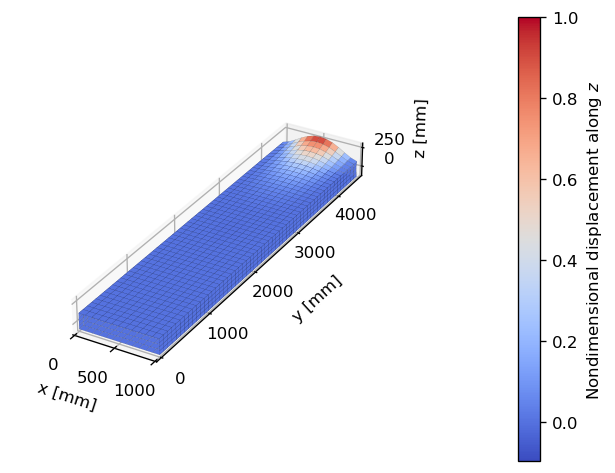

Applied load: 1306 N
Nonlinear deformation:


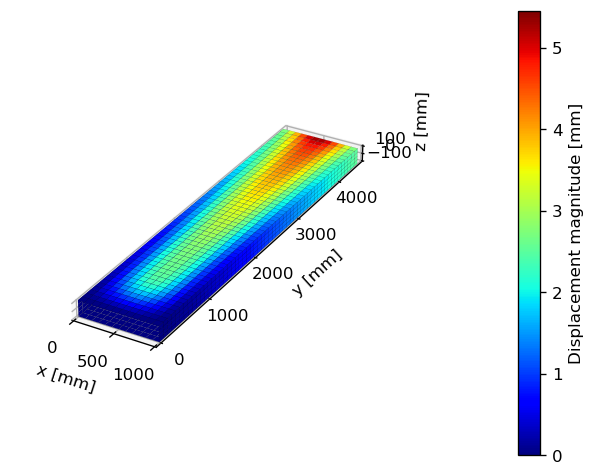

Predicted buckling load: 2706 N
Buckling shape:


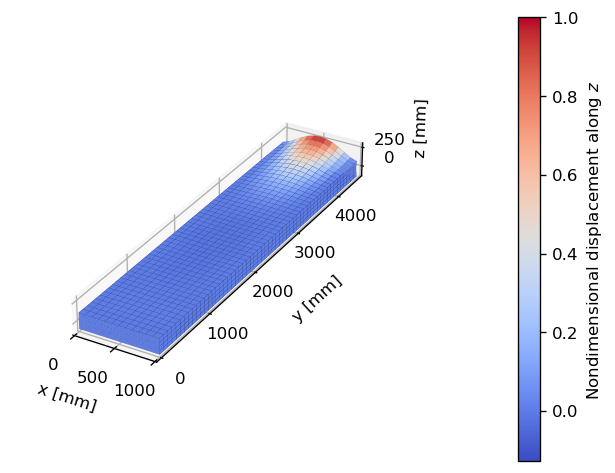

Applied load: 2610 N
Nonlinear deformation:


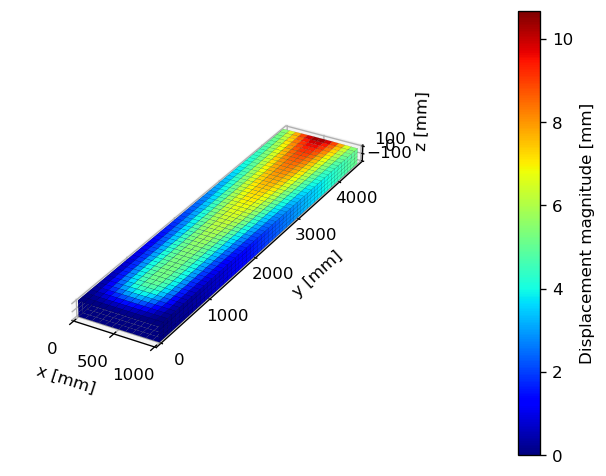

Predicted buckling load: 4085 N
Buckling shape:


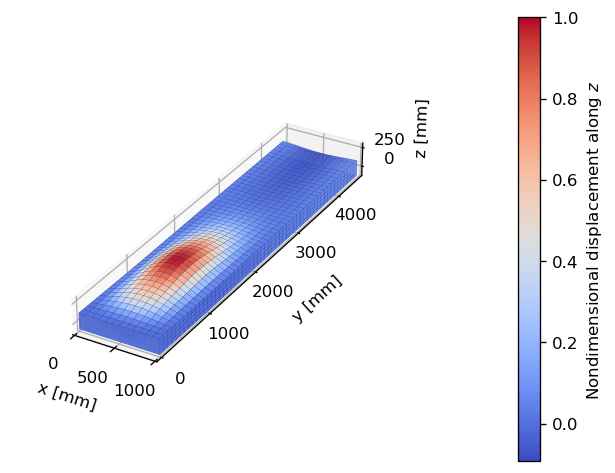

Applied load: 3915 N
Nonlinear deformation:


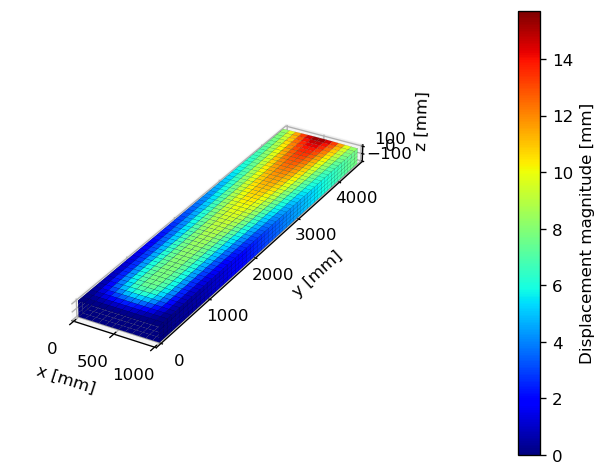

Predicted buckling load: 5421 N
Buckling shape:


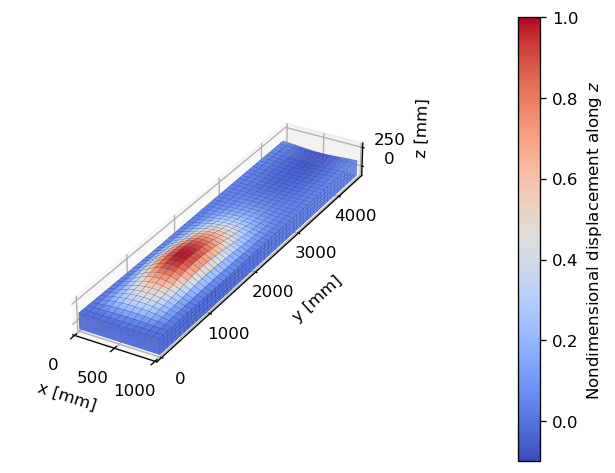

In [20]:
def plot_static_deformation(op2, subcase_id):
    # Call function from pynastran_utils module
    _, axes = pynastran_utils.plot_static_deformation(op2_object=op2, subcase_id=subcase_id)
    # Adjust axes' ticks and labels' position
    set_ticks_and_labels_position(axes)
    # Show plot
    plt.show()

def plot_buckling_mode(op2, subcase_id):
    # Call function from pynastran_utils module
    _, axes = pynastran_utils.plot_buckling_mode(op2_object=op2, subcase_id=subcase_id, displacement_component='tz', colormap='coolwarm')
    # Adjust axes' ticks and labels' position
    set_ticks_and_labels_position(axes)
    # Show plot
    plt.show()

# Plot displacements and buckling shape for each subcase
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]  # find valid keys associated to the subcases
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]  # find keys associated to the eigenvectors of the valid subcases
for count, applied_load in enumerate(applied_load_magnitudes):  # iterate through the prescribed load magnitudes (each corresponding to a different subcase)
    print(f'\033[1mApplied load: {applied_load:.0f} N\033[0m\nNonlinear deformation:')  # print info on the subcase
    plot_static_deformation(op2_output, valid_displacements_keys[count])  # plot static deformation at the end of the subcase
    print(f'Predicted buckling load: {nonlinear_buckling_loads[count]:.0f} N\nBuckling shape:')
    plot_buckling_mode(op2_output, eigenvector_keys[count])  # plot buckling shape predicted by nonlinear buckling method for the applied load of current subcase

Some observation can be made looking at the results.
- The critical buckling factor $\alpha$ is consistently above 1 by at least one order of magnitude, meaning that we should not trust the validity of the results obtained here.
- The nonlinear buckling load appears to have a linear relationship with the applied load and does not seem to converge to a certain value.
- The nonlinear buckling load for an applied load of 1 N is considerably smaller than the linear buckling load and this differs from our expectations. In fact, given its small deformation, the structure is very close to its undeformed state and, consequently, it would be reasonable to expect a buckling behavior similar to the one predicted by the linear analysis, which accounts only for the undeformed state of the structure. It is unclear why this happens, so further investigation is needed.
- The displacement field obtained from the nonlinear analysis is analogous for all applied loads and presents a peak of the displacement magnitude at the tip of the top skin. Since there is no rib to reinforce the sections of the box beam, the skin is relatively flexible and gets pulled out-of-plane by the distributed load. This behavior is evidently different from a classic global beam-like deformation where the sections of the beam stay substantially undeformed. The magnitude of the displacement peak suggests a linear behavior of the structure for the range of the applied loads investigated.
- Despite the analogous displacement fields, the first buckling shape appears to change with the magnitude of the applied load. For smaller load magnitudes the first buckling shape involves only the tip of the box beam, while for larger load magnitudes the displacement peak is located more inboard, resembling sligthly more the shape predicted by the linear buckling analysis. As a consequence, it appears that for small loads the buckling shape is more influenced by the local displacement of the top skin at the tip of the box beam, while for large loads the buckling shape is less influenced by that and resembles more the shape that would be expected for a structure having a global beam-like behavior.

### Rigid tip section <a name="distributed-load-rigid-tip"></a>

Let's try now to limit the out-of-plane displacement of the top skin observed at the tip for the previous nonlinear analyses. We are going to constrain the tip section of the box beam in order to make it rigid, keeping the same type of distributed load employed earlier.

We define a new base `BDF` object, apply the distributed load over the top skin and add a master node at the center of the tip section. We then add a RBE2 element that constrains all the nodes along the section of the tip to the master node, making the section rigid.

In [21]:
# Create base BDF object and apply distributed load over the top skin
rigid_tip_section_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)
apply_distributed_load_over_top_skin(rigid_tip_section_input, nodes_coordinates_array)

# Add master node of tip section
master_node_id = np.size(nodes_coordinates_array, 0) + 1
rigid_tip_section_input.add_grid(master_node_id, [w/2, b, 0.])

# Add RBE2 element to make tip section rigid
nodes_ids = np.arange(1, np.size(nodes_coordinates_array, 0) + 1)
tip_nodes_ids = nodes_ids[nodes_coordinates_array[:,1]==b]
rbe2_eid = len(rigid_tip_section_input.elements) + 1
rigid_tip_section_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)

subcase=0 already exists...skipping


RBE2        1729    1761  123456      55     110     165     220     275
             330     385     440     495     550     605     660     715
             770     825     880     935     990    1045    1100    1155
            1210    1265    1320    1375    1430    1485    1540    1595
            1650    1705    1760

We run a linear buckling analysis to check for any change in the buckling load and shape with respect to the configuration with a free tip section.

Buckling load: 3915 N
Buckling mode:


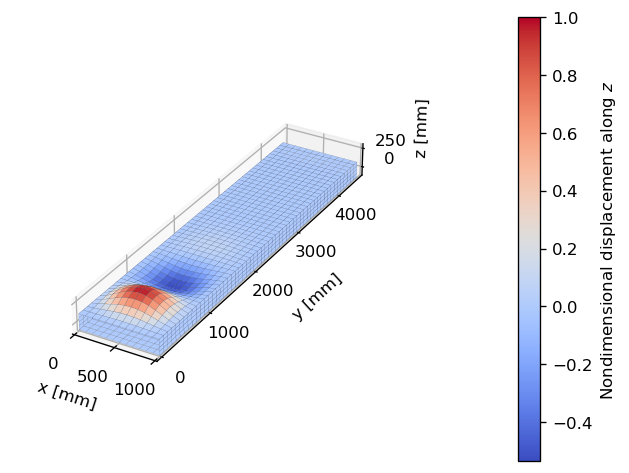

In [22]:
# Run SOL 105 and return OP2 object
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=rigid_tip_section_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='distributed_load_rigid_tip_linear_buckling', run_flag=False)

# Find critical buckling load and print it
linear_buckling_load = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling load: {linear_buckling_load:.0f} N')

# Plot critical buckling mode
print(f'Buckling mode:')
plot_buckling_mode(sol_105_op2, eigenvalue_calculation_subcase_id)

We can observe how both the buckling load and the buckling shape do not change with respect to the free tip configuration. The reason for this has to be found in the fact that the linear buckling analysis considers the structure in its undeformed state only and as a consequence it is not able to catch any difference between a free and a rigid tip section.

Now we switch to the nonlinear buckling analysis and we apply the same loads that we used for the free tip configuration.

Nastran job distributed_load_rigid_tip_nonlinear_buckling_method.bdf completed
Wall time: 43.0 s


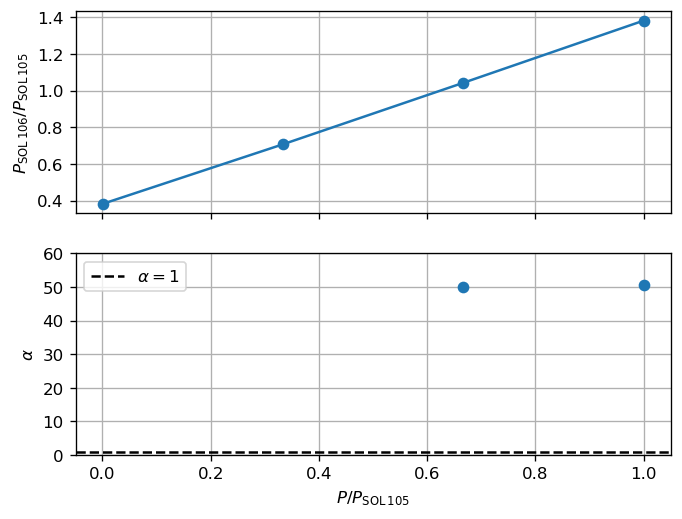

Applied load: 1 N
Nonlinear deformation:


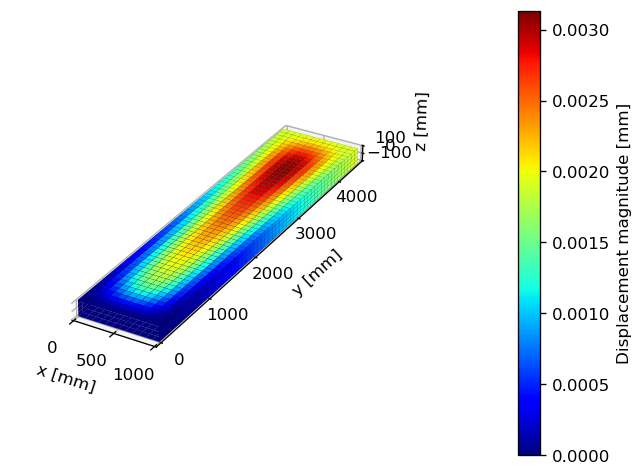

Predicted buckling load: 1496 N
Buckling shape:


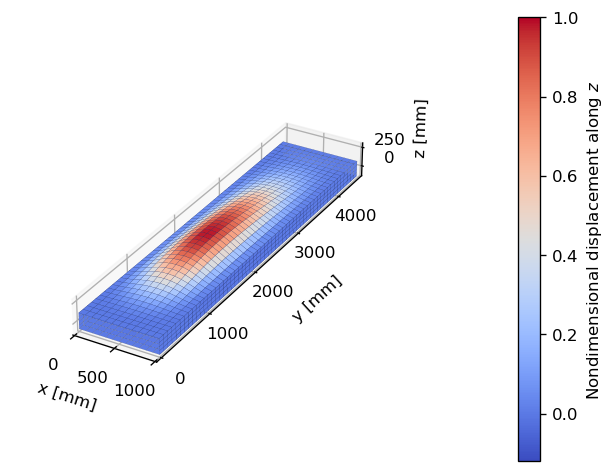

Applied load: 1306 N
Nonlinear deformation:


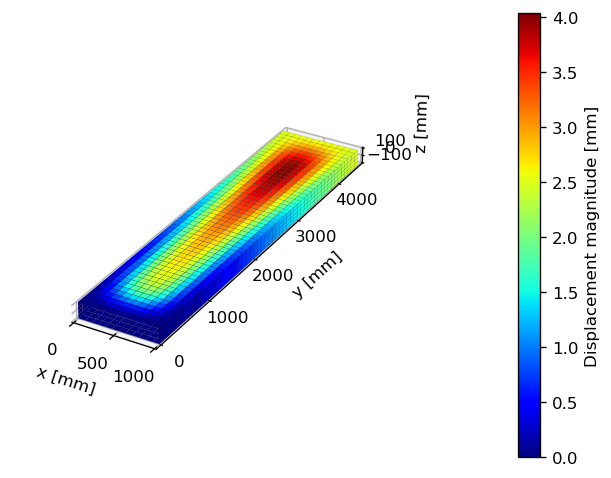

Predicted buckling load: 2767 N
Buckling shape:


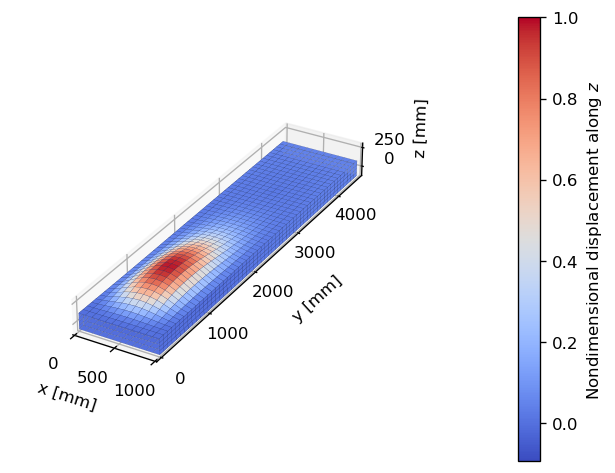

Applied load: 2610 N
Nonlinear deformation:


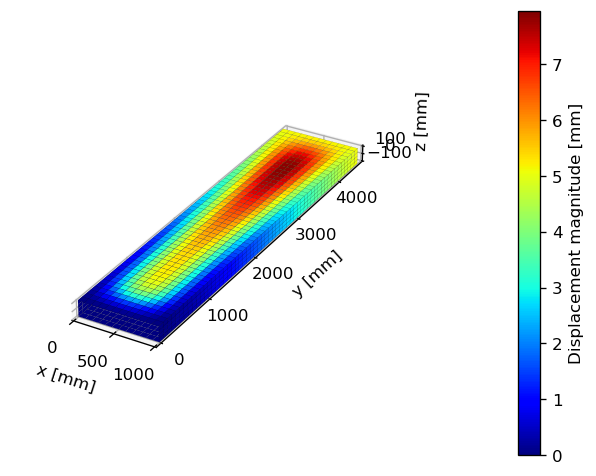

Predicted buckling load: 4080 N
Buckling shape:


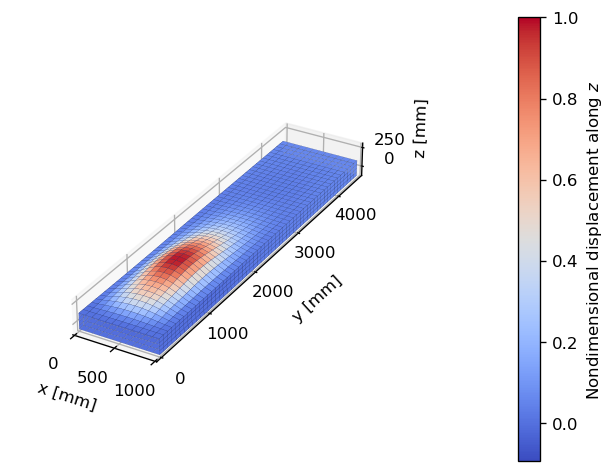

Applied load: 3915 N
Nonlinear deformation:


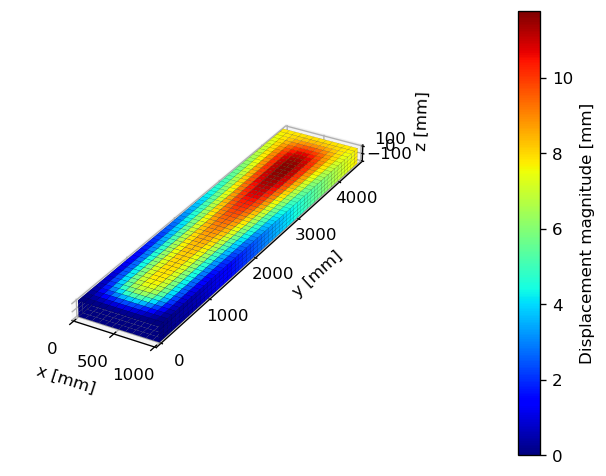

Predicted buckling load: 5408 N
Buckling shape:


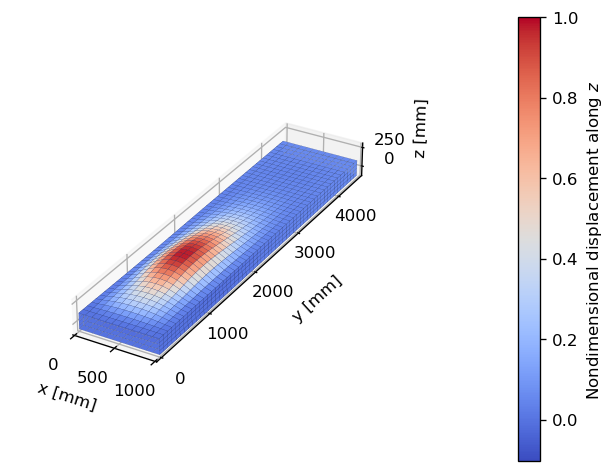

In [23]:
# Run nonlinear analysis
input_name = 'distributed_load_rigid_tip_nonlinear_buckling_method'
op2_output = run_nonlinear_buckling_method_sweep(rigid_tip_section_input, applied_load_magnitudes, input_name, run_flag=False)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)

# Plot results
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

# Plot displacements and buckling shape for each subcase
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]  # find valid keys associated to the subcases
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]  # find keys associated to the eigenvectors of the valid subcases
for count, applied_load in enumerate(applied_load_magnitudes):  # iterate through the prescribed load magnitudes (each corresponding to a different subcase)
    print(f'\033[1mApplied load: {applied_load:.0f} N\033[0m\nNonlinear deformation:')  # print info on the subcase
    plot_static_deformation(op2_output, valid_displacements_keys[count])  # plot static deformation at the end of the subcase
    print(f'Predicted buckling load: {nonlinear_buckling_loads[count]:.0f} N\nBuckling shape:')
    plot_buckling_mode(op2_output, eigenvector_keys[count])  # plot buckling shape predicted by nonlinear buckling method for the applied load of current subcase

Once again the critical buckling factor is largely above 1, suggesting that the obtained results should not be trusted. Also the buckling loads results are analogous to the flexible tip configuration, with an apparent linear behavior with the applied loads.

Looking at the nonlinear deformation plots, we can observe that with the rigid tip section, the displacement peak has moved sligthly more inboard with respect to what we found for the flexible tip configuration. In fact, if on one hand the rigid tip section eliminates the out-of-plane displacement of the top skin at the very tip of the box beam, we can still observe such behavior almost all over the span. Clearly, more rigid sections or the introduction of some ribs are needed to obtain a displacement field resembling a global beam-like kind of deformation.

Nevertheless, the presence of the rigid tip section seems to have a substantial effect on the buckling shape. In fact, there is no local buckling mode at the tip for small loads, in contrast to what was found for the flexible tip configuration. The displacement peak is located approximately at the center of the box beam along the span for an applied load of 1 N, while it moves more towards the root for larger loads. The buckling shape for large loads is similar to the one obtained with the flexible tip configuration. As a consequence it can be stated that the rigid tip section has a substantial influence only on the buckling behavior only for small applied loads.



## Concentrated load at the tip <a name="concentrated-load"></a>

***

Now we are going to change the type of load applied on our box beam. Instead of a distributed load over the top skin, we are going to load the structure with a concentrated force applied at the center of the tip section. We are going to investigate the response to this load with both a flexible and a rigid tip section.

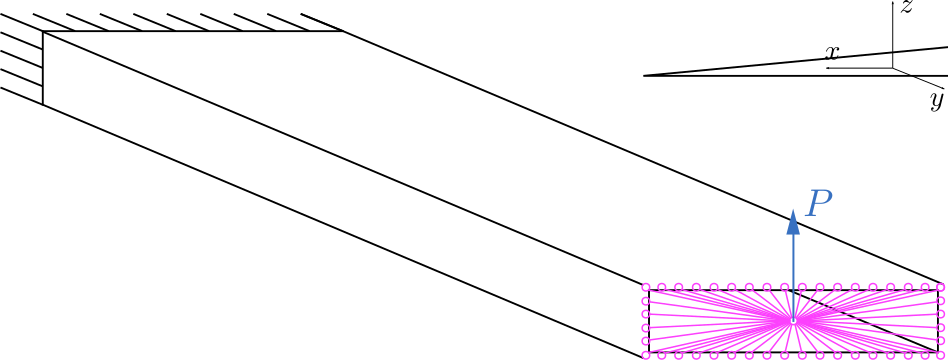

In [24]:
SVG(filename=os.path.join('resources', '04_BoxBeamConcentratedLoad.svg'))

### Flexible tip section <a name="concentrated-load-flexible-tip"></a>
Let's start by applying the concetrated load to a box beam with a flexible tip section. Similarly to the previous case with a rigid section, we create a base `BDF` object and we add a master node at the center of the tip section. This time we add a RBE3 element to connect the nodes of the section to the master node. This element allows us to introduce a force at the master node and to distribute it to the nodes of the tip section, where the motion of the master node is defined as a weighted average of the motions of the connected nodes. Finally, we add a concentrated upward force of 1 N at the master node using a FORCE card.

In [25]:
concentrated_load_flexible_tip_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)  # base BDF input

# Add RBE3 element to apply concentrated load at the master node
concentrated_load_flexible_tip_input.add_grid(master_node_id, [w/2, b, 0.])  # add master node of tip section
rbe3_eid = rbe2_eid  # identification number of RBE3 element
concentrated_load_flexible_tip_input.add_rbe3(eid=rbe3_eid, refgrid=master_node_id, refc='123456', weights=[1.]*len(tip_nodes_ids), comps=['123456']*len(tip_nodes_ids), Gijs=tip_nodes_ids)  # add RBE3 card

# Add concentrated force
concentrated_force_magnitude = 1.
concentrated_force_direction = [0., 0., 1.]
concentrated_load_flexible_tip_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)

subcase=0 already exists...skipping


FORCE         11    1761              1.      0.      0.      1.

Once again we calculate the linear buckling load and the corresponding shape.

Buckling load: 1657 N
Buckling mode:


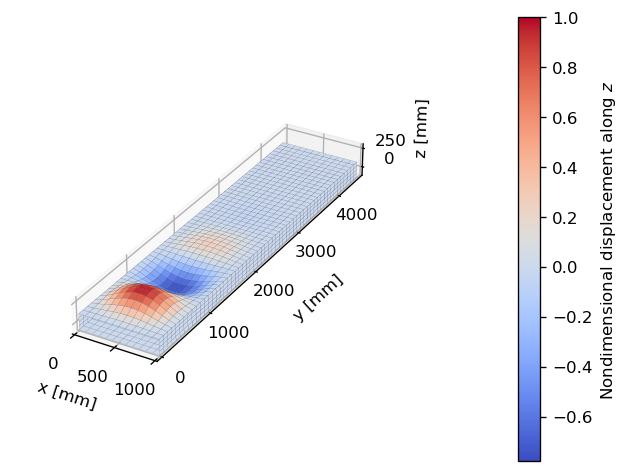

In [26]:
# Run SOL 105 and return OP2 object
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=concentrated_load_flexible_tip_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='concentrated_load_flexible_tip_linear_buckling', run_flag=False)

# Find critical buckling load and print it
linear_buckling_load = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling load: {linear_buckling_load:.0f} N')

# Plot critical buckling mode
print(f'Buckling mode:')
plot_buckling_mode(sol_105_op2, eigenvalue_calculation_subcase_id)

The predicted buckling shape is similar to the one of the case with a distributed load. The buckling load results smaller, as expected. In fact, since the force is only applied at the tip of the box beam, the effective moment arm with respect to the root is larger than the one of the distributed load case. As a consequence, a smaller force is needed to induce buckling in the structure.

Once again we run our nonlinear analyses applying 4 different load magnitudes, this time evenly distributed between 1 N and 1657 N.

Applied loads [N]: [   1.  553. 1105. 1657.]
Nastran job concentrated_load_flexible_tip_nonlinear_buckling_method.bdf completed
Wall time: 47.0 s


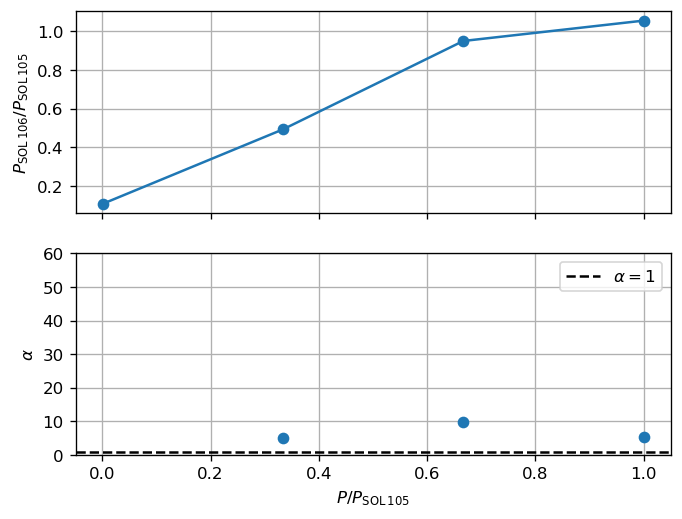

Applied load: 1 N
Nonlinear deformation:


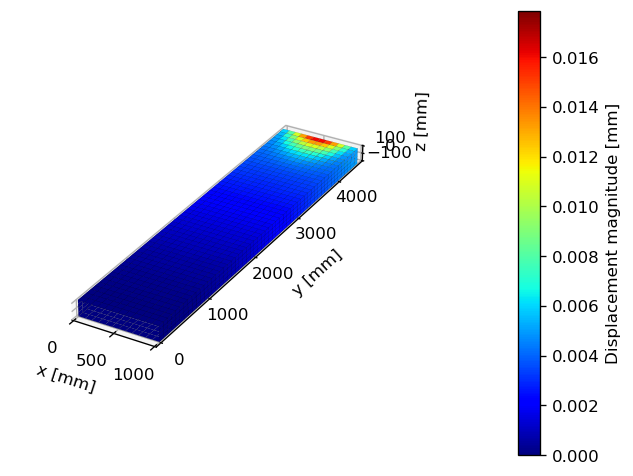

Predicted buckling load: 178 N
Buckling shape:


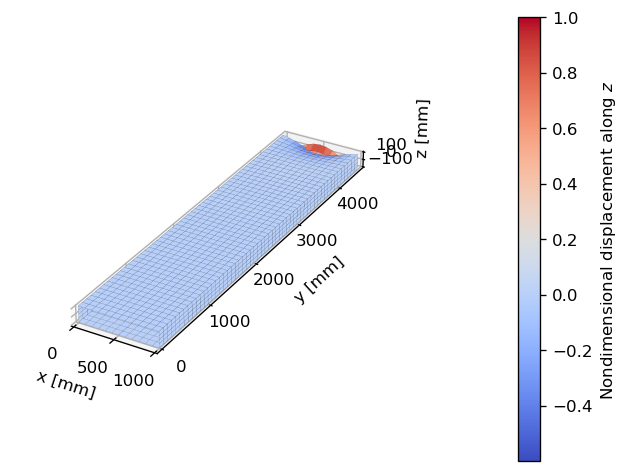

Applied load: 553 N
Nonlinear deformation:


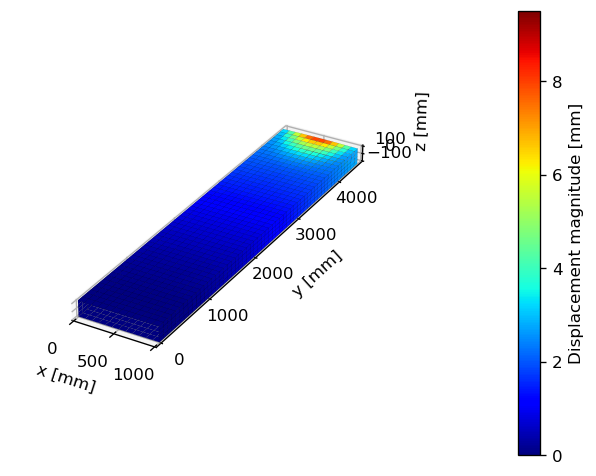

Predicted buckling load: 817 N
Buckling shape:


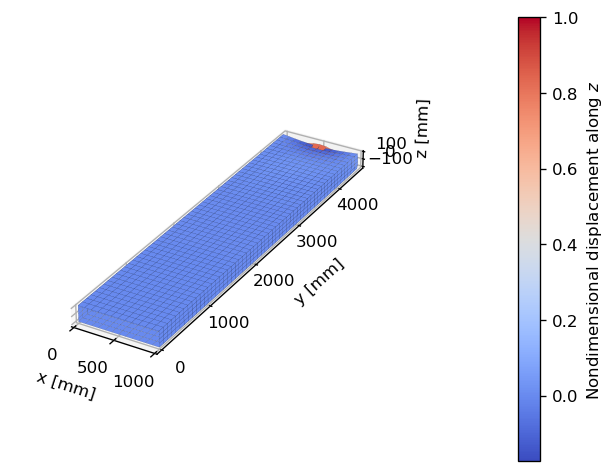

Applied load: 1105 N
Nonlinear deformation:


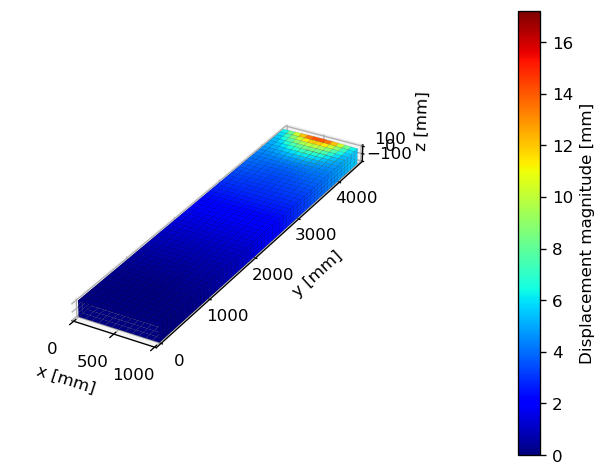

Predicted buckling load: 1574 N
Buckling shape:


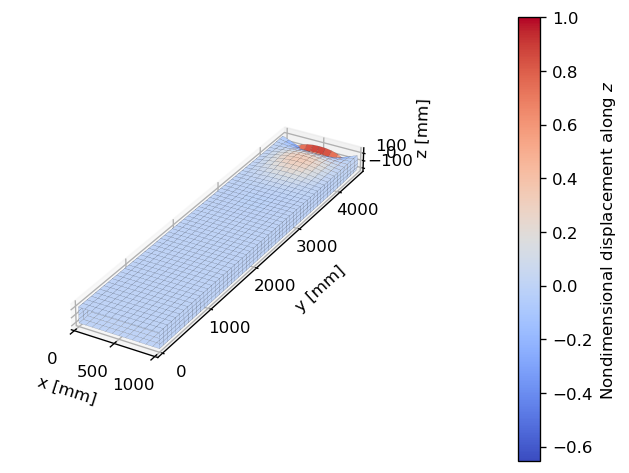

Applied load: 1657 N
Nonlinear deformation:


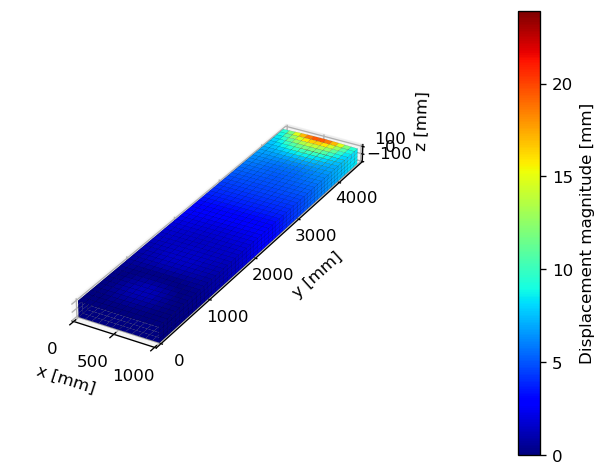

Predicted buckling load: 1749 N
Buckling shape:


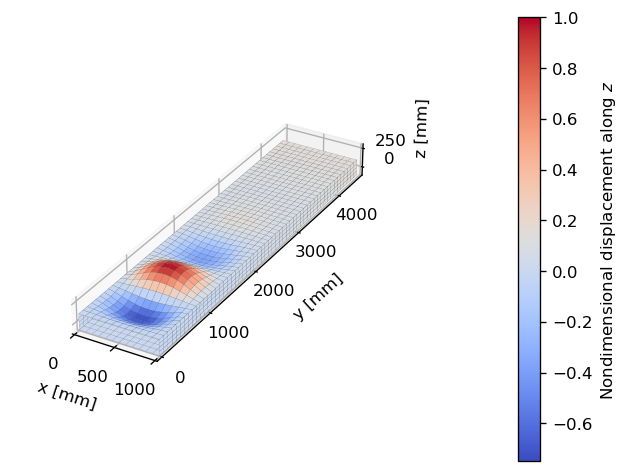

In [27]:
# Define magnitudes of applied load and print to screen
applied_load_magnitudes = np.linspace(1, linear_buckling_load, 4)
np.set_printoptions(precision=0, suppress=True)
print(f'Applied loads [N]: {applied_load_magnitudes}')

# Run analysis
input_name = 'concentrated_load_flexible_tip_nonlinear_buckling_method'
op2_output = run_nonlinear_buckling_method_sweep(concentrated_load_flexible_tip_input, applied_load_magnitudes, input_name, run_flag=False)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)

# Plot results
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

# Plot displacements and buckling shape for each subcase
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]  # find valid keys associated to the subcases
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]  # find keys associated to the eigenvectors of the valid subcases
for count, applied_load in enumerate(applied_load_magnitudes):  # iterate through the prescribed load magnitudes (each corresponding to a different subcase)
    print(f'\033[1mApplied load: {applied_load:.0f} N\033[0m\nNonlinear deformation:')  # print info on the subcase
    plot_static_deformation(op2_output, valid_displacements_keys[count])  # plot static deformation at the end of the subcase
    print(f'Predicted buckling load: {nonlinear_buckling_loads[count]:.0f} N\nBuckling shape:')
    plot_buckling_mode(op2_output, eigenvector_keys[count])  # plot buckling shape predicted by nonlinear buckling method for the applied load of current subcase

Also for this investigation, the critical buckling factor is consistently above 1, even if by a smaller amount with respect to the previous cases. The buckling loads appear to be linearly dependent from the applied loads, except for the largest applied load, where the linearity seems to break. However, the predicted buckling loads do not show a clear convergence towards a certain value. Furthermore, the buckling load obtained with an applied load of 1 N is again the farthest value from the linear buckling load, which is in constrast with what we would expected.

The displacement field obtained from the nonlinear static analyses is once again similar for all load magnitudes. However, this time the displacement does not appear to be distributed all along the span of the box beam, rather it is concentrated in the region of the tip. A small nonlinearity can be noted looking at the change of the magnitude of the displacement peak with the different applied loads.

The effect of the locally-dominated nonlinear displacement field can be clearly seen on the buckling shape. In fact, the buckling deformation is extremely localized at the tip of the box beam. Only for the case with the largest load magnitude, the buckling shape is very similar to the one predicted by the linear analysis, so closer to a structure having a global beam-like behavior. This seems to confirm the fact that the local deformation at the tip of the box beam has a different influence on the buckling behavior according to the level of applied load.

### Rigid tip section  <a name="concentrated-load-rigid-tip"></a>
Finally, we want to test the concentrated load with a rigid tip section. Analogously to the previous cases, we generate a base `BDF` object, add a master node at the center of the tip section, add an RBE2 element to constrain the section and add a concentrated load at the master node with a FORCE card. We then calculate the linear buckling load with the associated shape.

subcase=0 already exists...skipping


Buckling load: 1657 N
Buckling mode:


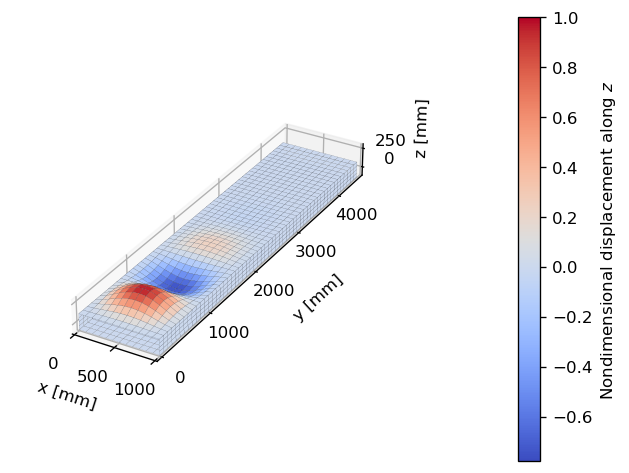

In [28]:
concentrated_load_rigid_tip_input = box_beam_utils.create_base_bdf_input(young_modulus=E, poisson_ratio=nu, density=rho, shell_thickness=t, nodes_xyz_array=nodes_coordinates_array, nodes_connectivity_matrix=nodes_connectivity_matrix)  # base BDF input
concentrated_load_rigid_tip_input.add_grid(master_node_id, [w/2, b, 0.])  # add master node of tip section
concentrated_load_rigid_tip_input.add_rbe2(rbe2_eid, master_node_id, '123456', tip_nodes_ids)  # add RBE2 element to make tip section rigid
concentrated_load_rigid_tip_input.add_force(sid=force_set_id, node=master_node_id, mag=concentrated_force_magnitude, xyz=concentrated_force_direction)  # add concentrated force

# Run SOL 105 and return OP2 object
sol_105_op2 = pynastran_utils.run_sol_105_buckling_analysis(bdf_object=concentrated_load_rigid_tip_input.__deepcopy__({}), static_load_set_id=force_set_id, analysis_directory_path=analysis_directory_path, input_name='concentrated_load_rigid_tip_linear_buckling', run_flag=False)

# Find critical buckling load and print it
linear_buckling_load = sol_105_op2.eigenvectors[eigenvalue_calculation_subcase_id].eigr
print(f'Buckling load: {linear_buckling_load:.0f} N')

# Plot critical buckling mode
print(f'Buckling mode:')
plot_buckling_mode(sol_105_op2, eigenvalue_calculation_subcase_id)

Also in this case we do not notice any difference in terms of buckling load and shape with respect to the flexible tip configuration, as expected.

We now run our nonlinear analyses in an analogous way as for the previous cases.

Nastran job concentrated_load_rigid_tip_nonlinear_buckling_method.bdf completed
Wall time: 40.0 s


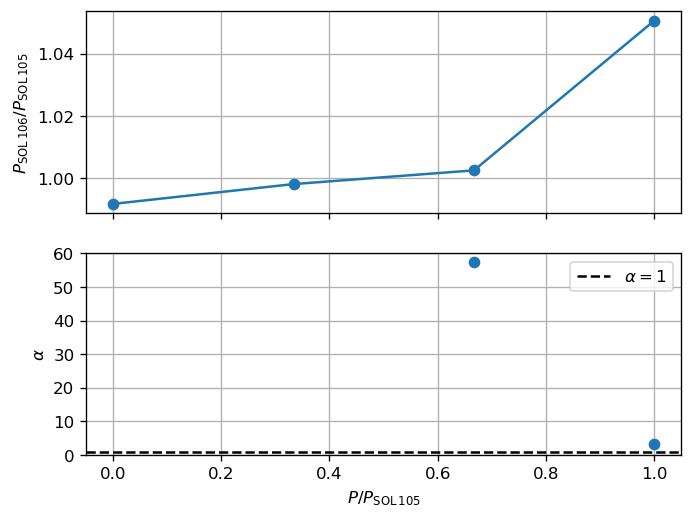

Applied load: 1 N
Nonlinear deformation:


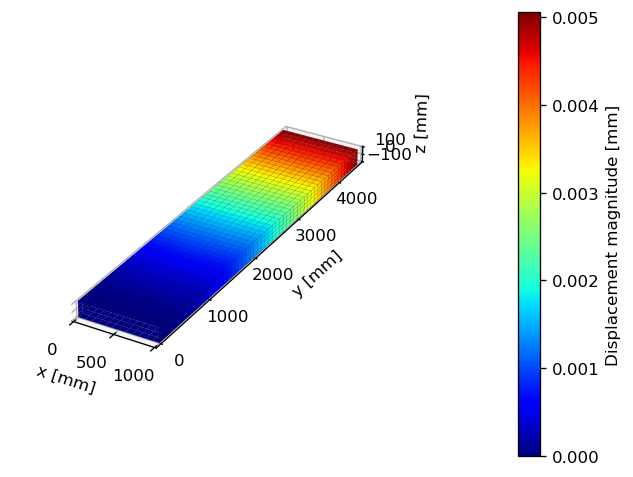

Predicted buckling load: 1643 N
Buckling shape:


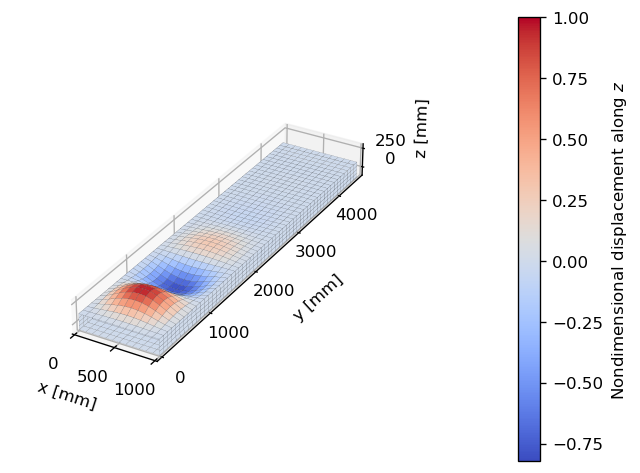

Applied load: 553 N
Nonlinear deformation:


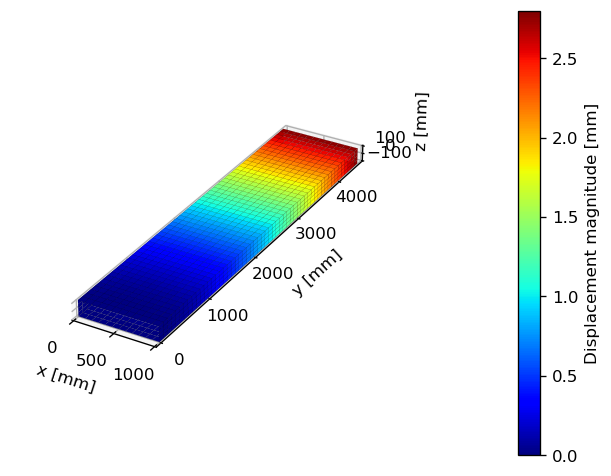

Predicted buckling load: 1654 N
Buckling shape:


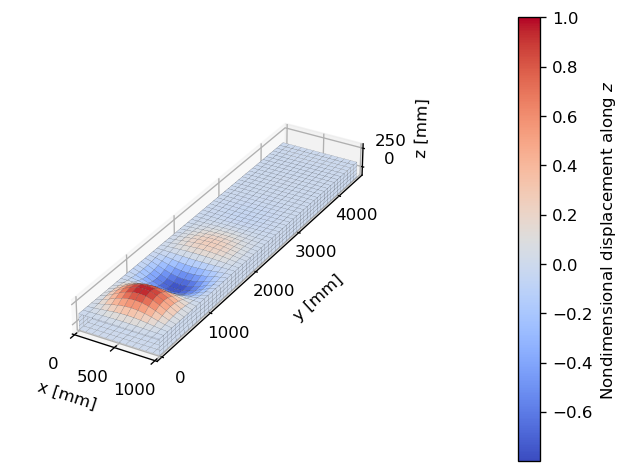

Applied load: 1105 N
Nonlinear deformation:


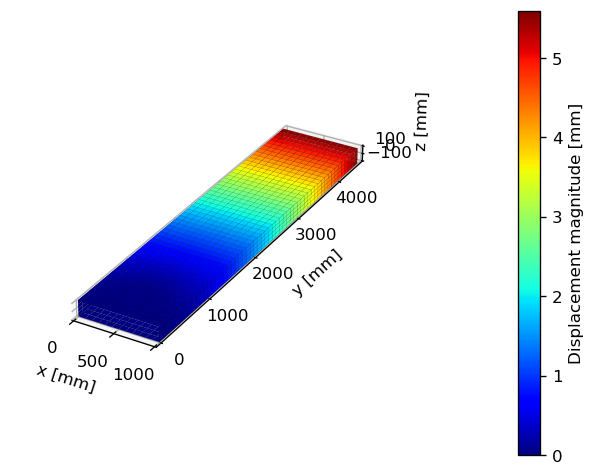

Predicted buckling load: 1661 N
Buckling shape:


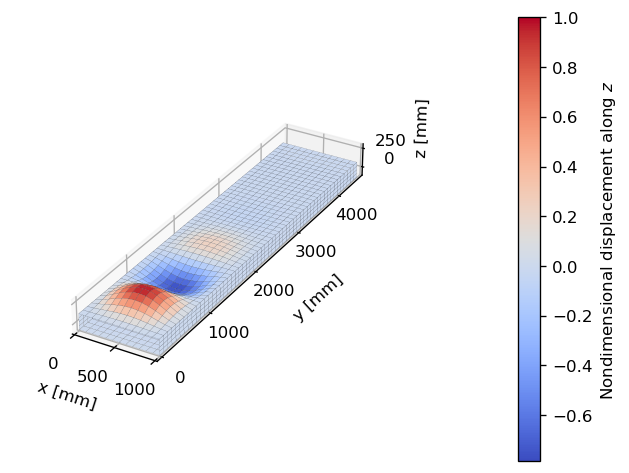

Applied load: 1657 N
Nonlinear deformation:


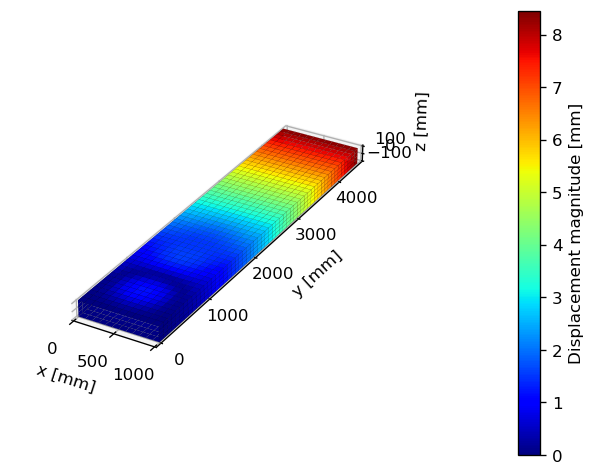

Predicted buckling load: 1741 N
Buckling shape:


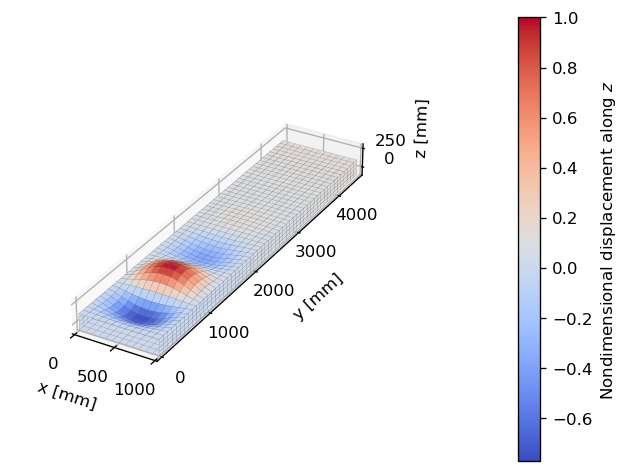

In [29]:
# Run nonlinear analysis
input_name = 'concentrated_load_rigid_tip_nonlinear_buckling_method'
op2_output = run_nonlinear_buckling_method_sweep(concentrated_load_rigid_tip_input, applied_load_magnitudes, input_name, run_flag=False)

# Find nonlinear buckling loads and critical buckling factors
nonlinear_buckling_loads, critical_buckling_factors = pynastran_utils.read_nonlinear_buckling_load_from_f06(f06_filepath=os.path.join(analysis_directory_path, input_name + '.f06'), op2_object=op2_output)

# Plot results
plot_buckling_loads(applied_load_magnitudes, linear_buckling_load, nonlinear_buckling_loads, critical_buckling_factors)

# Plot displacements and buckling shape for each subcase
valid_displacements_keys = [subcase_id for subcase_id in op2_output.displacements if hasattr(op2_output.displacements[subcase_id], 'lftsfqs')]  # find valid keys associated to the subcases
eigenvector_keys = [subcase_id for subcase_id in op2_output.eigenvectors]  # find keys associated to the eigenvectors of the valid subcases
for count, applied_load in enumerate(applied_load_magnitudes):  # iterate through the prescribed load magnitudes (each corresponding to a different subcase)
    print(f'\033[1mApplied load: {applied_load:.0f} N\033[0m\nNonlinear deformation:')  # print info on the subcase
    plot_static_deformation(op2_output, valid_displacements_keys[count])  # plot static deformation at the end of the subcase
    print(f'Predicted buckling load: {nonlinear_buckling_loads[count]:.0f} N\nBuckling shape:')
    plot_buckling_mode(op2_output, eigenvector_keys[count])  # plot buckling shape predicted by nonlinear buckling method for the applied load of current subcase

The critical buckling factor is once again consistently above 1. Similarly to the flexible configuration, the buckling loads appear to have a linear relationship with the applied loads except for the last applied load.

In terms of deformation and buckling shape, in this case we can observe a global beam-like behavior for both. The displacement field of the nonlinear deformation is distributed from the root to the tip of the box beam for all the applied loads. Furthermore, the structure appears to have a linear response looking at the displacement peaks for the range of loads investigated. The buckling shape resembles closely the one predicted by the linear analysis for all the analyses. As far as the buckling loads are concerned, all values predicted by the nonlinear analysis are closer to the one predicted by the linear analysis but also here there is no clear convergence to a certain value.

## Conclusions <a name="conclusions"></a>

***

All the investigated cases were characterized by the following features:
- critical buckling factor $\alpha$ consistently larger than 1;
- no convergence of the buckling load predicted by SOL 106's nonlinear buckling method for increasing applied loads;
- the buckling load predicted for a small applied load (1 N) is very far from the linear buckling prediction.

These results shed doubts on the use of Nastran's nonlinear buckling method to study the nonlinear buckling behavior of wing-like structures. The first follow-up step consists in making sure that the results obtained do not depend on the nonlinear analysis parameters employed here. For this reason, in our [next notebook](05_Sensitivity_Study_of_SOL_106_Nonlinear_Analysis_Parameters.ipynb) we will perform a sensitivity study on such parameters.